One of the main tasks in the final phases of the ENCODE4 project is to integrate work from different subgroups. Here, we will try to see how the ATAC-/WG-STARR-seq signal changes the ABC scores for a set of candidate regulatory elements already defined (and kept fixed).

In [1]:
pwd

'/gpfs/fs1/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg'

In [2]:
%%bash
mkdir -p /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data
mkdir -p /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs
mkdir -p /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/scripts
mkdir -p /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
sns.set_context('notebook')
sns.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.markersize'] = 20

In [ ]:
#df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.txt.gz', sep='\t')
# ^-- this breaks (out of memory, large file) 

In [ ]:
%%bash
gzip -dc /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.txt.gz \
| tail -n+2 \
| cut -f1-3 \
| uniq \
| sort -u -k1,1 -k2,2n \
> /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/putative_enhancers.bed

In [2]:
pwd

'/gpfs/fs1/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg'

In [3]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/multiBamSummary.putative_enhancers.out \
    --mem=64G \
    --exclude=dl-01 \
    --cpus-per-task 16 \
    <<'EOF'
#!/bin/bash
multiBamSummary BED-file \
    --bamfiles \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep1.f3q10.sorted.with_umis.dups_marked.bam \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep2.f3q10.sorted.with_umis.dups_marked.bam \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep3.f3q10.sorted.with_umis.dups_marked.bam \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep4.f3q10.sorted.with_umis.dups_marked.bam \
    --BED \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/putative_enhancers.bed \
    -o \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.putative_enhancers.npz \
    --outRawCounts \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.putative_enhancers.txt \
    --samFlagExclude 1024 \
    -p 16
EOF

Submitted batch job 27576488


Detour-- Create input-subtracted bigwigs from STARR-seq signal

In [28]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/bamCompare.subtract_input_from_output.astarr.%a.out \
    --mem=32G \
    --exclude=dl-01 \
    --cpus-per-task 8 \
    --array=1-4 \
    <<'EOF'
#!/bin/bash
REP=${SLURM_ARRAY_TASK_ID}
mkdir -p /data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}
export TMPDIR="/data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}"
export TMP="/data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}"
bamCompare  \
    --bamfile1 \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep${REP}.f3q10.sorted.with_umis.dups_marked.bam \
    --bamfile2 \
        /data/reddylab/Alex/encode4_duke/processing/atac_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-blacklist-removal/merged2/KS91_K562_hg38_ASTARRseq_Input_rep${REP}.masked.dups_marked.sorted.bam \
    -o \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep${REP}.input_subtracted.pseudo_10.bw \
    --samFlagExclude 1024 \
    --binSize 1 \
    --operation subtract \
    --pseudocount 10 \
    --scaleFactorsMethod None \
    --normalizeUsing CPM \
    -p 8
EOF

Submitted batch job 27848126


In [4]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/multiBigwigSummary.putative_enhancers.input_subtracted_astarr.out \
    --mem=64G \
    --exclude=dl-01 \
    --cpus-per-task 16 \
    <<'EOF'
#!/bin/bash
multiBigwigSummary BED-file \
    --bwfiles \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep1.input_subtracted.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep2.input_subtracted.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep3.input_subtracted.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep4.input_subtracted.bw \
    --BED \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/putative_enhancers.bed \
    -o \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.input_subtracted.putative_enhancers.npz \
    --outRawCounts \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.input_subtracted.putative_enhancers.txt \
    -p 16
EOF

Submitted batch job 27847226


In [1]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/bamCompare.subtract_input_from_output.astarr.log2.%a.out \
    --mem=32G \
    --exclude=dl-01 \
    --cpus-per-task 8 \
    --array=1-4 \
    <<'EOF'
#!/bin/bash
REP=${SLURM_ARRAY_TASK_ID}
mkdir -p /data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}
export TMPDIR="/data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}"
export TMP="/data/reddylab/Alex/tmp/bamCompare.subtract_input_from_output.astarr.rep${REP}"
bamCompare  \
    --bamfile1 \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep${REP}.f3q10.sorted.with_umis.dups_marked.bam \
    --bamfile2 \
        /data/reddylab/Alex/encode4_duke/processing/atac_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-blacklist-removal/merged2/KS91_K562_hg38_ASTARRseq_Input_rep${REP}.masked.dups_marked.sorted.bam \
    -o \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep${REP}.log2.pseudo_10.bw \
    --samFlagExclude 1024 \
    --binSize 1 \
    --operation log2 \
    --pseudocount 10 \
    --scaleFactorsMethod None \
    --normalizeUsing CPM \
    -p 8
EOF

Submitted batch job 28035350


In [1]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/multiBigwigSummary.putative_enhancers.log2.pseudo_10_astarr.out \
    --mem=64G \
    --exclude=dl-01 \
    --cpus-per-task 16 \
    <<'EOF'
#!/bin/bash
multiBigwigSummary BED-file \
    --bwfiles \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep1.log2.pseudo_10.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep2.log2.pseudo_10.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep3.log2.pseudo_10.bw \
        /data/reddylab/Alex/encode4_duke/processing/starr_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-umis/KS91_K562_hg38_ASTARRseq_Output_rep4.log2.pseudo_10.bw \
    --BED \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/putative_enhancers.bed \
    -o \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.log2.pseudo_10.putative_enhancers.npz \
    --outRawCounts \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.log2.pseudo_10.putative_enhancers.txt \
    -p 16
EOF

Submitted batch job 28130687


In [9]:
from scipy import interpolate
x = np.arange(0, 10, 1)
y = np.arange(2, 6, (6.-2)/10.)
f = interpolate.interp1d(x, y)

In [16]:
f(0)

array(2.)

In [2]:
df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.putative_enhancers.txt', sep='\t')

df['ASTARR.RPM'] = np.median(1e6*df.iloc[:, 3:]/df.iloc[:, 3:].sum(), axis=1)

df.index = df.apply(lambda x: "%s_%d_%d" % (x["#'chr'"], x["'start'"],x["'end'"]), axis=1)

df = pd.DataFrame(df.loc[:, 'ASTARR.RPM'])

In [33]:
# abc_df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.txt.gz', sep='\t',
#                     usecols=['chr', 'start', 'end', 'H3K27ac.RPM.quantile', 'DHS.RPM.quantile', 'powerlaw_contact_reference', 'TargetGene'])

In [ ]:
%%bash
gzip -dc /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.txt.gz  \
| cut -f1-3,11,21,38,42,51,53 \
| awk -v OFS='\t' '{print $1"_"$2"_"$3, $0}' \
>  /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.simple.txt

In [66]:
%%bash
gzip -dc /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.txt.gz  \
| cut -f1-3,33,36,38,42,51,53 \
| awk -v OFS='\t' '{print $1"_"$2"_"$3, $0}' \
>  /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.simple.v2.txt

In [3]:
abc_df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.simple.v2.txt', sep='\t', index_col=0)


In [ ]:
# abc_df.index = abc_df.apply(lambda x: "%s_%d_%d" % (x["chr"], x["start"],x["end"]), axis=1)

In [4]:
from scipy import interpolate

def run_qnorm(df, qnorm, qnorm_method = "rank", separate_promoters = True):
    # Quantile normalize epigenetic data to a reference
    #
    # Option to qnorm promoters and nonpromoters separately

    if qnorm is None:
        if 'H3K27ac.RPM' in df.columns: df['normalized_h3K27ac'] = df['H3K27ac.RPM']
        if 'DHS.RPM' in df.columns: df['normalized_dhs'] = df['DHS.RPM']
        if 'ATAC.RPM' in df.columns: df['normalized_atac'] = df['ATAC.RPM']
    else:
        qnorm = pd.read_csv(qnorm, sep = "\t")
        nRegions = df.shape[0] 
        col_dict = {'DHS.RPM' : 'normalized_dhs', 'ATAC.RPM' : 'normalized_atac', 
                    'H3K27ac.RPM' : 'normalized_h3K27ac', 'ASTARR.RPM': 'normalized_astarr', 
                    'WGSTARR.RPM': 'normalized_wgstarr'}

        for col in set(df.columns & col_dict.keys()):
            #if there is no ATAC.RPM in the qnorm file, but there is ATAC.RPM in enhancers, then qnorm ATAC to DHS
            if col == 'ATAC.RPM' and 'ATAC.RPM' not in qnorm.columns:
                qnorm['ATAC.RPM'] = qnorm['DHS.RPM']
            #if there is no ASTAR.RPM in the qnorm file, but there is ASTARR.RPM in enhancers, then qnorm ASTARR to DHS
            if col == 'ASTARR.RPM' and 'ASTARR.RPM' not in qnorm.columns:
                qnorm['ASTARR.RPM'] = qnorm['DHS.RPM']
            if col == 'WGSTARR.RPM' and 'WGSTARR.RPM' not in qnorm.columns:
                qnorm['WGSTARR.RPM'] = qnorm['DHS.RPM']

            if not separate_promoters:
                qnorm = qnorm.loc[qnorm['enh_class'] == "any", :]
                if qnorm_method == "rank":
                    interpfunc = interpolate.interp1d(qnorm['rank'], qnorm[col], kind='linear', fill_value='extrapolate')
                    df[col_dict[col]] = interpfunc((1 - df[col + ".quantile"]) * nRegions).clip(0)
                elif qnorm_method == "quantile":
                    interpfunc = interpolate.interp1d(qnorm['quantile'], qnorm[col], kind='linear', fill_value='extrapolate')
                    df[col_dict[col]] = interpfunc(df[col + ".quantile"]).clip(0)
            else:
                for enh_class in ['promoter','nonpromoter']:
                    this_qnorm = qnorm.loc[qnorm['enh_class'] == enh_class]

                    #Need to recompute quantiles within each class
                    if enh_class == 'promoter':
                        this_idx = df.index[np.logical_or(df['enh_class'] == "tss", df['enh_class'] == "promoter")]
                    else:
                        this_idx = df.index[np.logical_and(df['enh_class'] != "tss" , df['enh_class'] != "promoter")]
                    df.loc[this_idx, col + enh_class + ".quantile"] = df.loc[this_idx, col].rank()/len(this_idx)

                    if qnorm_method == "rank":
                        interpfunc = interpolate.interp1d(this_qnorm['rank'], this_qnorm[col], kind='linear', fill_value='extrapolate')
                        df.loc[this_idx, col_dict[col]] = interpfunc((1 - df.loc[this_idx, col + enh_class + ".quantile"]) * len(this_idx)).clip(0)
                    elif qnorm_method == "quantile":
                        interpfunc = interpolate.interp1d(this_qnorm['quantile'], this_qnorm[col], kind='linear', fill_value='extrapolate')
                        df.loc[this_idx, col_dict[col]] = interpfunc(df.loc[this_idx, col + enh_class + ".quantile"]).clip(0)

    return df

In [5]:
df_qnorm = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancersQNormRef.K562.txt', sep = '\t')

In [6]:
df['ASTARR.RPM.quantile'] = df['ASTARR.RPM'].rank() / float(df.shape[0])

In [7]:
df2 = run_qnorm(df, '/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancersQNormRef.K562.txt',
              qnorm_method = 'quantile',  separate_promoters = False )

In [8]:
abc_df = abc_df.join(df2)

In [9]:
def compute_score(enhancers, product_terms, prefix, geometric_mean=True):

    scores = np.column_stack(product_terms).prod(axis = 1)
    if geometric_mean:
        scores = np.power(scores, 1/len(product_terms))
    enhancers[prefix + '.Score.Numerator'] = scores
    enhancers[prefix + '.Score'] = enhancers[prefix + '.Score.Numerator'] / enhancers.groupby('TargetGene')[prefix + '.Score.Numerator'].transform('sum')
    enhancers.drop(prefix + '.Score.Numerator', axis=1, inplace=True)
    return(enhancers)

In [ ]:
activity_cols_list = [
    ['normalized_dhs', 'normalized_h3K27ac', 'normalized_astarr'],
    ['normalized_astarr', 'normalized_h3K27ac'],
    ['normalized_dhs', 'normalized_astarr'],
    ['normalized_astarr']
]
for ac in activity_cols_list:
    activity_col_name = '_'.join([c.split('_')[-1] for c in ac])
    abc_df['activity_%s' % activity_col_name] = \
        np.power(abc_df.loc[:, ac].prod(axis=1), 1/len(ac))

abc_df = compute_score(abc_df, [abc_df['activity_dhs_h3K27ac_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_h3K27ac_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr_h3K27ac'], abc_df['powerlaw_contact_reference']], 'astarr_h3k27ac', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_dhs_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr'], abc_df['powerlaw_contact_reference']], 'astarr', geometric_mean=False)


In [10]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, method='Pearson', **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    if method == 'Spearman':
        r, _ = spearmanr(x, y)
    elif method == 'Pearson':
        r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = u'\u03C1'
    ax.annotate('%s %s = %.2f' % (method, rho, r), xy=(.1, .9), xycoords=ax.transAxes)

In [11]:
from palettable.cartocolors.qualitative import Bold_9

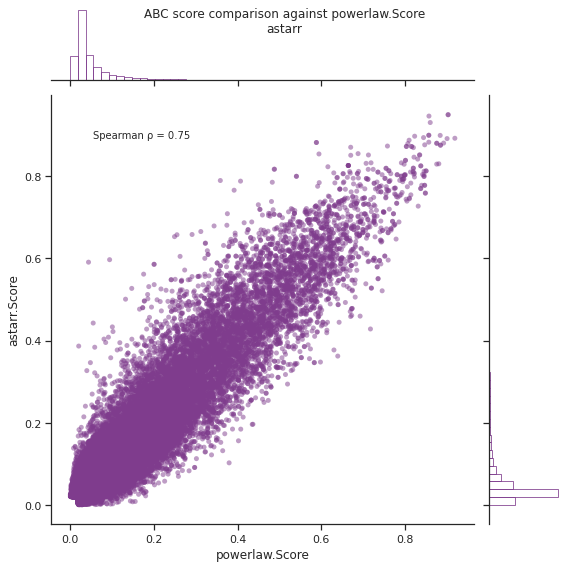

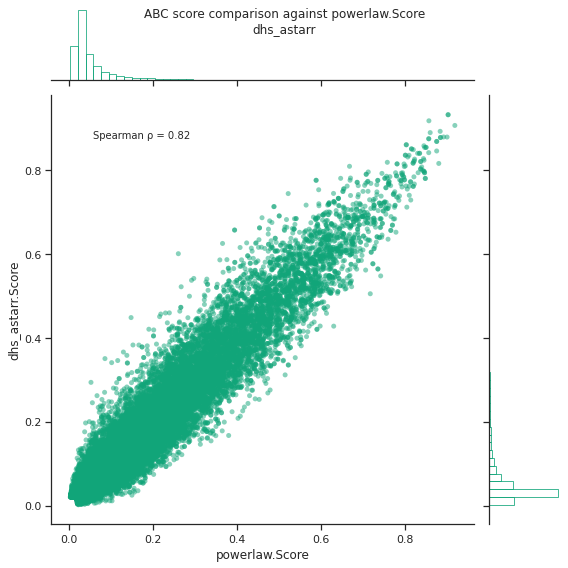

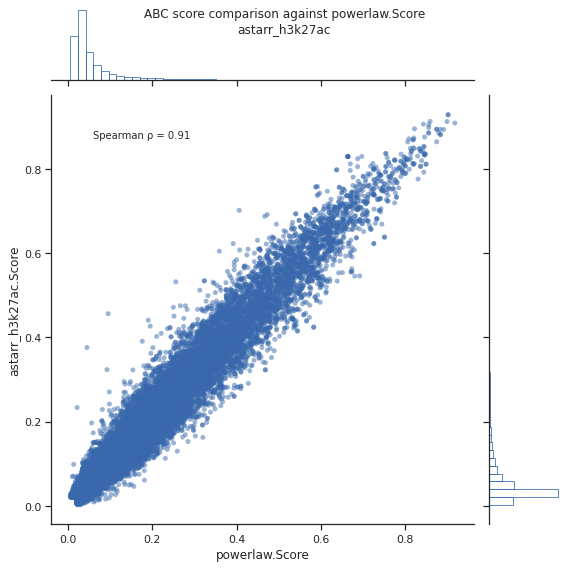

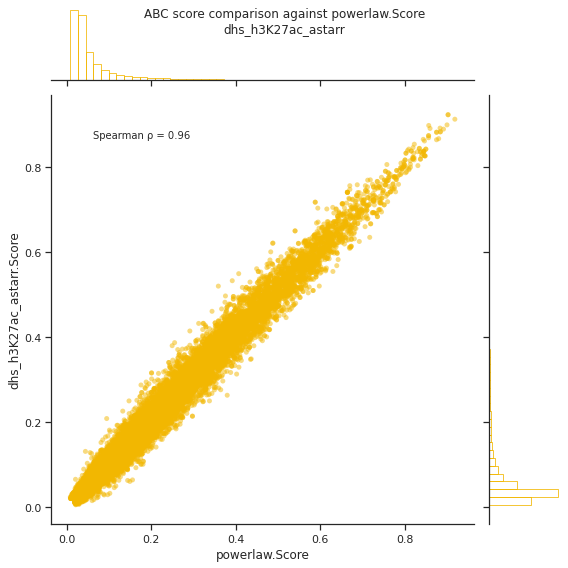

In [51]:
datadir='/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results'
for s_ix, ss in enumerate(['astarr', 'dhs_astarr', 'astarr_h3k27ac', 'dhs_h3K27ac_astarr']):
    g= sns.jointplot(
        data=abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score', '%s.Score'%ss]], 
        x='powerlaw.Score', y='%s.Score'%ss, color=Bold_9.hex_colors[s_ix],
        marker="o", s=25, marginal_kws=dict(bins=50, fill=False), alpha=.5,height=8, 
        ec="none", joint_kws = dict(rasterized=False)
    )
    corrfunc(    
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score']].values.flatten(),
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['%s.Score'%ss]].values.flatten(),
        ax=g.ax_joint, method='Spearman'
    )
    
    plt.suptitle("ABC score comparison against powerlaw.Score\n%s" % ss)
    g.savefig('%s/abc_score_comparison.%s_vs_powerlaw.pdf' % (datadir, ss))

WG-STARR-seq

In [32]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/multiBamSummary.wgstarr.putative_enhancers.out \
    --mem=64G \
    --exclude=dl-01 \
    --cpus-per-task 16 \
    <<'EOF'
#!/bin/bash
multiBamSummary BED-file \
    --bamfiles \
        /data/reddylab/kstrouse/superstarr/output_libs/A001_K562/A001_K562_20210213/processing/starr_seq/Strouse_6825_210223A5-pe/A001-K562-rep2.f3q10.sorted.dups_marked.bam \
        /data/reddylab/kstrouse/superstarr/output_libs/A001_K562/A001_K562_20210213/processing/starr_seq/Strouse_6825_210223A5-pe/A001-K562-rep3.f3q10.sorted.dups_marked.bam \
        /data/reddylab/kstrouse/superstarr/output_libs/A001_K562/A001_K562_20201124/combined_reads/processing/starr_seq/A001_K562_20201124_combined-pe/A001-K562-rep1.f3q10.sorted.dups_marked.bam \
    --BED \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/putative_enhancers.bed \
    -o \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/WGSTARRseq.A001_K562.putative_enhancers.npz \
    --outRawCounts \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/WGSTARRseq.A001_K562.putative_enhancers.txt \
    -p 16
EOF

Submitted batch job 27577356


In [34]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3_dev
sbatch -o /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/logs/bamCompare.wgstarr.log2.%a.out \
    --array=1 \
    --mem=32G \
    --exclude=dl-01 \
    --cpus-per-task 8 \
    <<'EOF'
#!/bin/bash
REP=${SLURM_ARRAY_TASK_ID}
if [[ ${REP} == 1 ]];
then
    OUTPUT_STARR="/data/reddylab/kstrouse/superstarr/output_libs/A001_K562/A001_K562_20201124/combined_reads/processing/starr_seq/A001_K562_20201124_combined-pe/A001-K562-rep1.f3q10.sorted.dups_marked.bam"
else
    OUTPUT_STARR="/data/reddylab/kstrouse/superstarr/output_libs/A001_K562/A001_K562_20210213/processing/starr_seq/Strouse_6825_210223A5-pe/A001-K562-rep${REP}.f3q10.sorted.dups_marked.bam"
fi
bamCompare  \
    --bamfile1 \
        ${OUTPUT_STARR} \
    --bamfile2 \
        /data/reddylab/kstrouse/superstarr/input_libs/A001/combined_reads/processing/starr_seq/A001_combined-pe/A001.f3q10.sorted.dups_marked.bam \
    -o \
        /data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/WGSTARRseq.A001_K562.log2fc.rep${REP}.log2.pseudo_10.bw \
    --samFlagExclude 1024 \
    --binSize 1 \
    --operation log2 \
    --pseudocount 10 \
    --scaleFactorsMethod None \
    --normalizeUsing CPM \
    -p 8
EOF

Submitted batch job 28159997


In [35]:
len('CCAATGCTAAAAAGGAAACATTCCCCAACCCTTCCAGAGGAACCGTTTTCCCAGGGCTGTCCCTAGGATGGCTGGAATTCCTCTAATTGTGTGAGGAGGAGTCAGAGGCTCTGCTGCTGAACAACAGGAAGCAGAGCCCCCAAACACACTCGAGGGCATGCACACAGAGGCGCACGCACGCACAAGGGCATGGACACACACATAGACACGCAAGCATCTGTGCATACACAGTCACATATGGAGGT')

245

In [36]:
541-293

248

In [5]:
pwd

'/gpfs/fs1/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg'

In [ ]:
wg_starr_df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/WGSTARRseq.A001_K562.putative_enhancers.txt', sep='\t')
wg_starr_df['WGSTARR.RPM'] = np.median(1e6*wg_starr_df.iloc[:, 3:]/wg_starr_df.iloc[:, 3:].sum(), axis=1)
wg_starr_df.index = wg_starr_df.apply(lambda x: "%s_%d_%d" % (x["#'chr'"], x["'start'"],x["'end'"]), axis=1)
wg_starr_df = pd.DataFrame(wg_starr_df.loc[:, 'WGSTARR.RPM'])

In [ ]:
wg_starr_df['WGSTARR.RPM.quantile'] = wg_starr_df['WGSTARR.RPM'].rank() / float(wg_starr_df.shape[0])

In [ ]:
wg_starr_df2 = run_qnorm(wg_starr_df, '/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancersQNormRef.K562.txt',
              qnorm_method = 'quantile',  separate_promoters = False )

In [ ]:
abc_df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.simple.v2.txt', sep='\t', index_col=0)

In [ ]:
abc_df = abc_df.join(wg_starr_df2)

In [ ]:
activity_cols_list = [
    ['normalized_dhs', 'normalized_h3K27ac', 'normalized_wgstarr'],
    ['normalized_wgstarr', 'normalized_h3K27ac'],
    ['normalized_dhs', 'normalized_wgstarr'],
    ['normalized_wgstarr']
]
for ac in activity_cols_list:
    activity_col_name = '_'.join([c.split('_')[-1] for c in ac])
    abc_df['activity_%s' % activity_col_name] = \
        np.power(abc_df.loc[:, ac].prod(axis=1), 1/len(ac))

In [ ]:
abc_df = compute_score(abc_df, [abc_df['activity_dhs_h3K27ac_wgstarr'], abc_df['powerlaw_contact_reference']], 'dhs_h3K27ac_wgstarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_wgstarr_h3K27ac'], abc_df['powerlaw_contact_reference']], 'wgstarr_h3k27ac', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_dhs_wgstarr'], abc_df['powerlaw_contact_reference']], 'dhs_wgstarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_wgstarr'], abc_df['powerlaw_contact_reference']], 'wgstarr', geometric_mean=False)


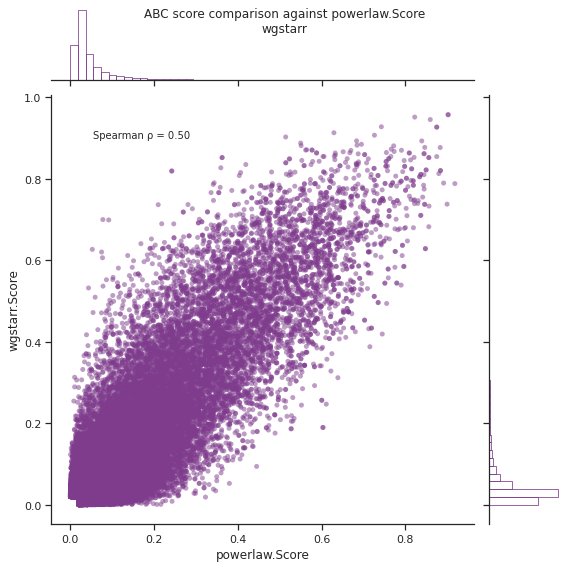

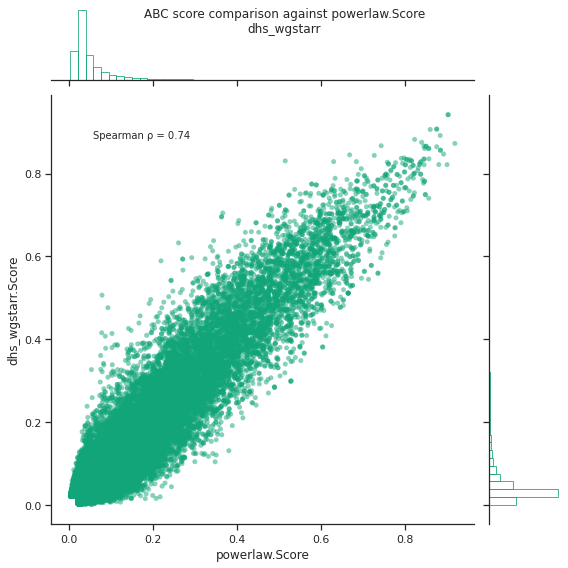

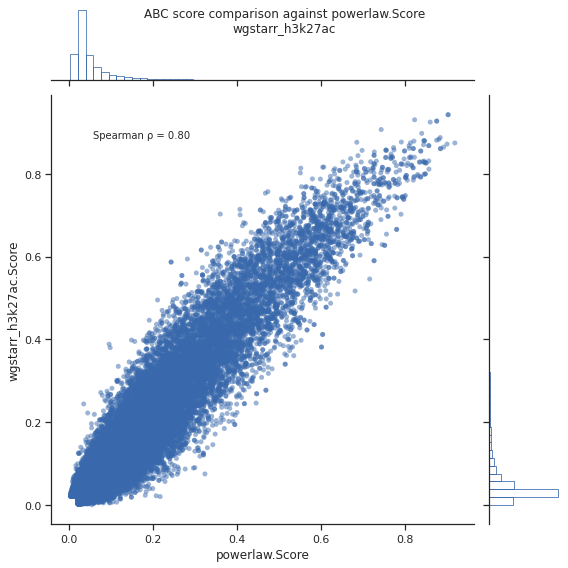

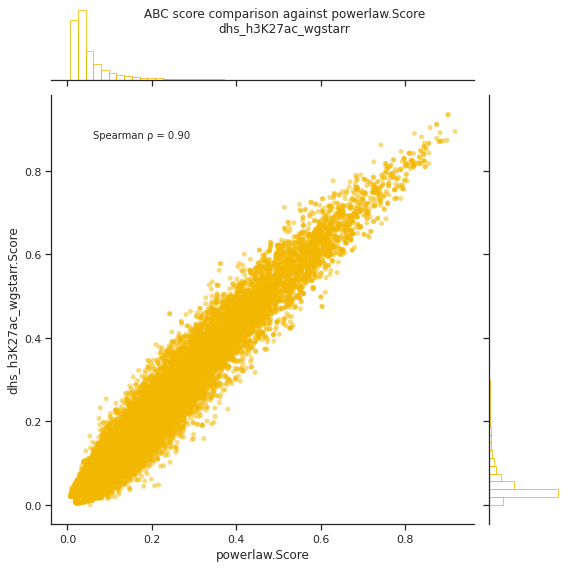

In [65]:
datadir='/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results'
for s_ix, ss in enumerate(['wgstarr', 'dhs_wgstarr', 'wgstarr_h3k27ac', 'dhs_h3K27ac_wgstarr']):
    g= sns.jointplot(
        data=abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score', '%s.Score'%ss]], 
        x='powerlaw.Score', y='%s.Score'%ss, color=Bold_9.hex_colors[s_ix],
        marker="o", s=25, marginal_kws=dict(bins=50, fill=False), alpha=.5,height=8, 
        ec="none", joint_kws = dict(rasterized=True)
    )
    corrfunc(    
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score']].values.flatten(),
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['%s.Score'%ss]].values.flatten(),
        ax=g.ax_joint, method='Spearman'
    )
    
    plt.suptitle("ABC score comparison against powerlaw.Score\n%s" % ss)
    g.savefig('%s/abc_score_comparison.%s_vs_powerlaw.rasterized.pdf' % (datadir, ss))

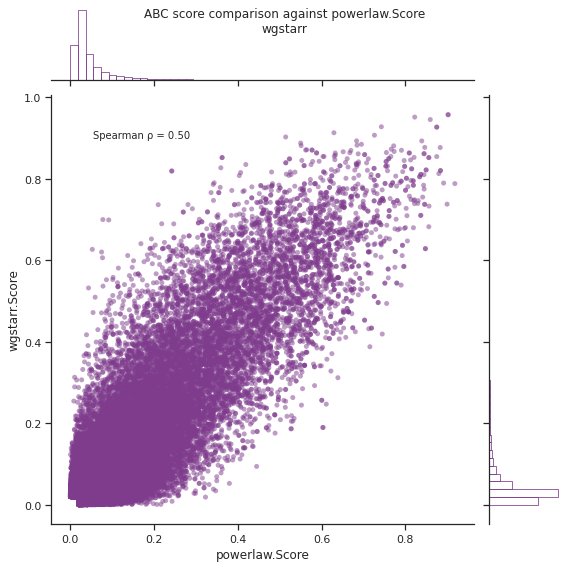

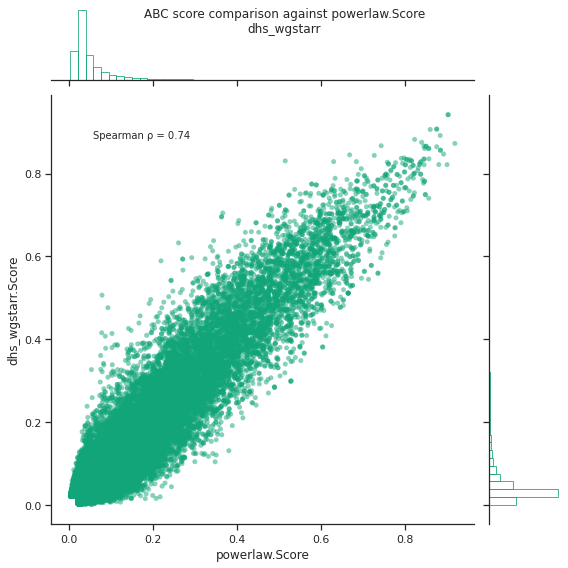

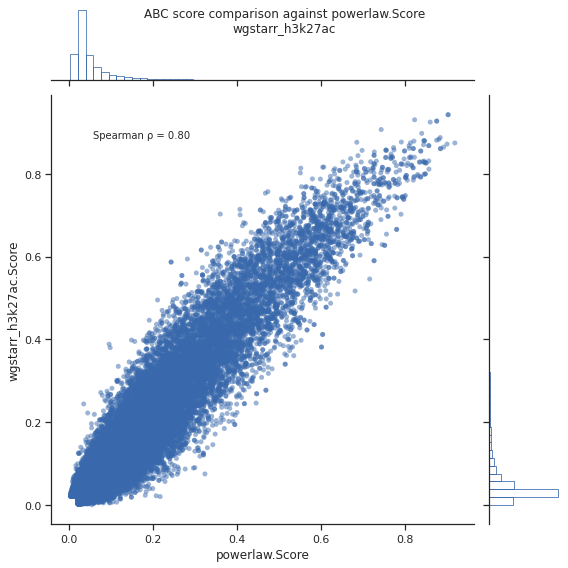

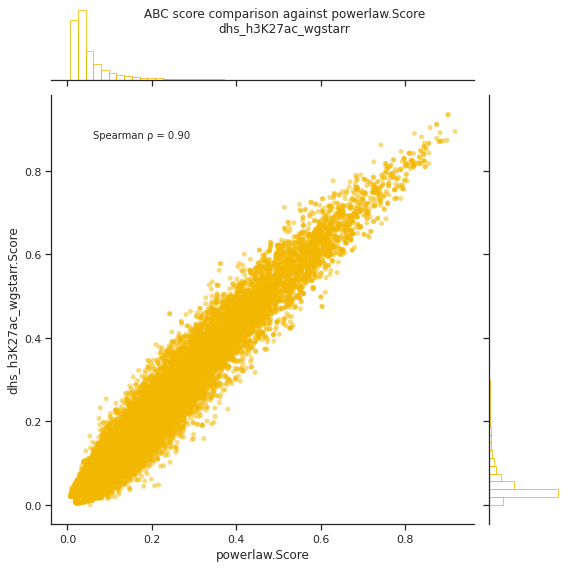

In [65]:
datadir='/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results'
for s_ix, ss in enumerate(['wgstarr', 'dhs_wgstarr', 'wgstarr_h3k27ac', 'dhs_h3K27ac_wgstarr'][:1]):
    g= sns.jointplot(
        data=abc_df.loc[np.any(abc_df.loc[:, ['astarr.Score','%s.Score'%ss]]>.02, axis=1),
                        ['astarr.Score', '%s.Score'%ss]], 
        x='astarr.Score', y='%s.Score'%ss, color=Bold_9.hex_colors[s_ix],
        marker="o", s=25, marginal_kws=dict(bins=50, fill=False), alpha=.5,height=8, 
        ec="none", joint_kws = dict(rasterized=True)
    )
    corrfunc(    
        abc_df.loc[np.any(abc_df.loc[:, ['astarr.Score','%s.Score'%ss]]>.02, axis=1),
                        ['astarr.Score']].values.flatten(),
        abc_df.loc[np.any(abc_df.loc[:, ['astarr.Score','%s.Score'%ss]]>.02, axis=1),
                        ['%s.Score'%ss]].values.flatten(),
        ax=g.ax_joint, method='Spearman'
    )
    
    plt.suptitle("ABC score comparison against astarr.Score\n%s" % ss)
    g.savefig('%s/abc_score_comparison.%s_vs_astarr.rasterized.pdf' % (datadir, ss))

In [ ]:
abc_df

In [54]:
wg_starr_df.head()

,WGSTARR.RPM
chrX_26778255_26778755,3.502188
chrX_26783438_26783938,7.273776
chr13_106376312_106376812,6.239967
chrX_20442553_20443053,4.786170
chr14_67618559_67619059,3.142990


----
Using input subtracted ASTARR

In [5]:
df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.input_subtracted.putative_enhancers.txt', sep='\t')

df['ASTARR.RPM'] = np.median(1e6*df.iloc[:, 3:]/df.iloc[:, 3:].sum(), axis=1)

df.index = df.apply(lambda x: "%s_%d_%d" % (x["#'chr'"], x["'start'"],x["'end'"]), axis=1)

df = pd.DataFrame(df.loc[:, 'ASTARR.RPM'])

In [19]:
df.describe()

,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr
count,128422.000000,128422.000000,128422.000000
mean,7.454782,0.500004,2.832359
std,69.358390,0.288676,5.135168
min,-500.348904,0.000008,0.000000
25%,-7.470310,0.250006,0.650290
50%,-1.912618,0.500004,1.170881
75%,4.678761,0.750002,2.654036
max,3363.278813,1.000000,118.295930


In [10]:
df['ASTARR.RPM.quantile'] = df['ASTARR.RPM'].rank() / float(df.shape[0])

In [11]:
df2 = run_qnorm(df, '/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancersQNormRef.K562.txt',
              qnorm_method = 'quantile',  separate_promoters = False )

In [12]:
abc_df = abc_df.join(df2)

In [27]:
df.describe()

,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr
count,128422.000000,128422.000000,128422.000000
mean,7.454782,0.500004,2.832359
std,69.358390,0.288676,5.135168
min,-500.348904,0.000008,0.000000
25%,-7.470310,0.250006,0.650290
50%,-1.912618,0.500004,1.170881
75%,4.678761,0.750002,2.654036
max,3363.278813,1.000000,118.295930


In [23]:
df2.head()

,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr
chr10_48988_49488,-0.980239,0.554547,1.349901
chr10_76344_76844,-7.267328,0.255930,0.660811
chr10_87090_87679,-13.870049,0.135031,0.498536
chr10_134113_135702,-48.144632,0.032245,0.081135
chr10_135735_136530,-37.082891,0.044681,0.136143


In [22]:
abc_df.head()

,chr,start,end,normalized_dhs,normalized_h3K27ac,activity_base,TargetGene,powerlaw_contact_reference,powerlaw.Score,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr,activity_dhs_h3K27ac_astarr,activity_astarr_h3K27ac,activity_dhs_astarr,activity_astarr,dhs_h3K27ac_astarr.Score,astarr_h3k27ac.Score,dhs_astarr.Score,astarr.Score
chr10_100006022_100006725,chr10,100006022,100006725,2.893976,2.001807,2.406903,PDLIM1,0.000319,0.000186,7.249602,0.790277,3.223081,2.652952,2.540076,3.054099,3.223081,0.000263,0.000295,0.000269,0.000306
chr10_100006022_100006725,chr10,100006022,100006725,2.893976,2.001807,2.406903,ALDH18A1,0.000342,0.000284,7.249602,0.790277,3.223081,2.652952,2.540076,3.054099,3.223081,0.000355,0.000370,0.000361,0.000378
chr10_100006022_100006725,chr10,100006022,100006725,2.893976,2.001807,2.406903,TCTN3,0.000345,0.000321,7.249602,0.790277,3.223081,2.652952,2.540076,3.054099,3.223081,0.000446,0.000514,0.000433,0.000507
chr10_100006022_100006725,chr10,100006022,100006725,2.893976,2.001807,2.406903,ENTPD1,0.000349,0.000399,7.249602,0.790277,3.223081,2.652952,2.540076,3.054099,3.223081,0.000476,0.000509,0.000441,0.000451
chr10_100006022_100006725,chr10,100006022,100006725,2.893976,2.001807,2.406903,CCNJ,0.000371,0.000251,7.249602,0.790277,3.223081,2.652952,2.540076,3.054099,3.223081,0.000412,0.000401,0.000499,0.000518


In [15]:
activity_cols_list = [
    ['normalized_dhs', 'normalized_h3K27ac', 'normalized_astarr'],
    ['normalized_astarr', 'normalized_h3K27ac'],
    ['normalized_dhs', 'normalized_astarr'],
    ['normalized_astarr']
]
for ac in activity_cols_list:
    activity_col_name = '_'.join([c.split('_')[-1] for c in ac])
    abc_df['activity_%s' % activity_col_name] = \
        np.power(abc_df.loc[:, ac].prod(axis=1), 1/len(ac))

abc_df = compute_score(abc_df, [abc_df['activity_dhs_h3K27ac_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_h3K27ac_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr_h3K27ac'], abc_df['powerlaw_contact_reference']], 'astarr_h3k27ac', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_dhs_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr'], abc_df['powerlaw_contact_reference']], 'astarr', geometric_mean=False)


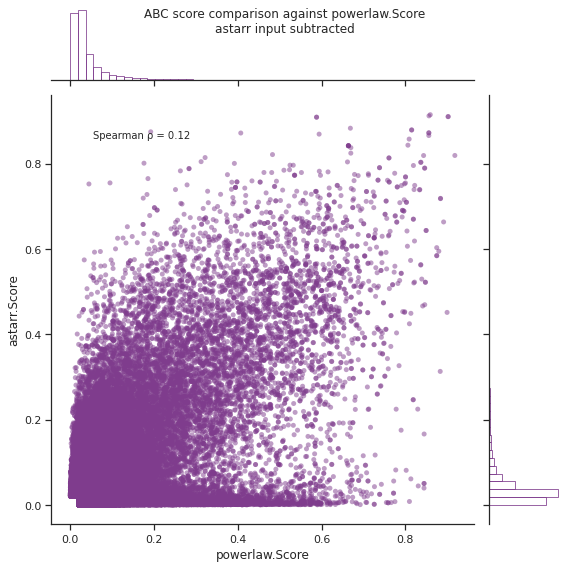

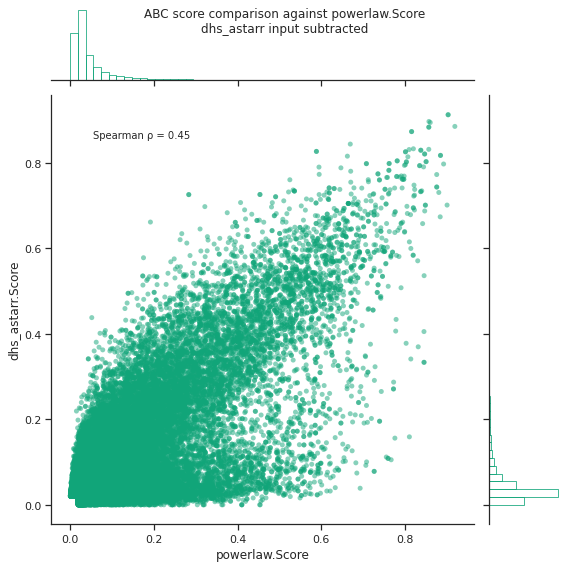

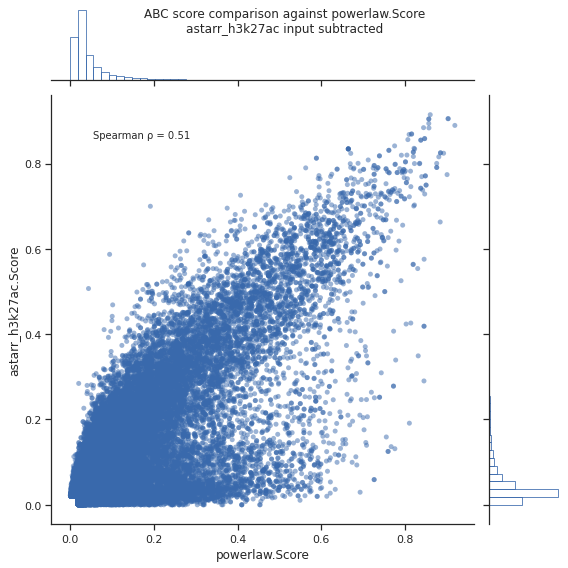

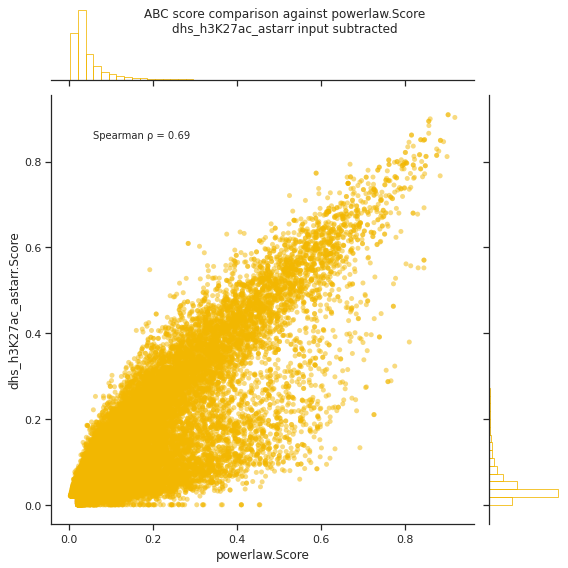

In [16]:
datadir='/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results'
for s_ix, ss in enumerate(['astarr', 'dhs_astarr', 'astarr_h3k27ac', 'dhs_h3K27ac_astarr']):
    g= sns.jointplot(
        data=abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score', '%s.Score'%ss]], 
        x='powerlaw.Score', y='%s.Score'%ss, color=Bold_9.hex_colors[s_ix],
        marker="o", s=25, marginal_kws=dict(bins=50, fill=False), alpha=.5,height=8, 
        ec="none", joint_kws = dict(rasterized=False)
    )
    corrfunc(    
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score']].values.flatten(),
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['%s.Score'%ss]].values.flatten(),
        ax=g.ax_joint, method='Spearman'
    )
    
    plt.suptitle("ABC score comparison against powerlaw.Score\n%s input subtracted" % ss)
    g.savefig('%s/abc_score_comparison.%s_input_subtracted_vs_powerlaw.pdf' % (datadir, ss))

In [21]:
abc_df[[c for c in abc_df.columns if c.startswith('normalized')]]

,normalized_dhs,normalized_h3K27ac,normalized_astarr
chr10_100006022_100006725,2.893976,2.001807,3.223081
chr10_100006022_100006725,2.893976,2.001807,3.223081
chr10_100006022_100006725,2.893976,2.001807,3.223081
chr10_100006022_100006725,2.893976,2.001807,3.223081
chr10_100006022_100006725,2.893976,2.001807,3.223081
...,...,...,...
chrX_9995688_9996188,1.449485,0.204720,0.686510
chrX_9995688_9996188,1.449485,0.204720,0.686510
chrX_9995688_9996188,1.449485,0.204720,0.686510
chrX_9995688_9996188,1.449485,0.204720,0.686510


----
Using log2(output/input) ASTARR

In [12]:
df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/ASTARRseq_Output.log2.pseudo_10.putative_enhancers.txt', sep='\t')
df['ASTARR.RPM'] = np.median(1e6*df.iloc[:, 3:]/df.iloc[:, 3:].sum(), axis=1)
df.index = df.apply(lambda x: "%s_%d_%d" % (x["#'chr'"], x["'start'"],x["'end'"]), axis=1)
df = pd.DataFrame(df.loc[:, 'ASTARR.RPM'])

In [13]:
df.describe()

,ASTARR.RPM
count,128422.000000
mean,7.566950
std,74.863506
min,-580.762129
25%,-11.424367
50%,-2.975483
75%,7.079397
max,2090.825455


In [14]:
df['ASTARR.RPM.quantile'] = df['ASTARR.RPM'].rank() / float(df.shape[0])

In [15]:
df2 = run_qnorm(df, '/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancersQNormRef.K562.txt',
              qnorm_method = 'quantile',  separate_promoters = False )

In [17]:
abc_df = pd.read_csv('/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/data/EnhancerPredictionsAllPutative.simple.v2.txt', sep='\t', index_col=0)

In [18]:
abc_df = abc_df.join(df2)

In [20]:
df.describe()

,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr
count,128422.000000,128422.000000,128422.000000
mean,7.566950,0.500004,2.832359
std,74.863506,0.288676,5.135168
min,-580.762129,0.000008,0.000000
25%,-11.424367,0.250006,0.650290
50%,-2.975483,0.500004,1.170881
75%,7.079397,0.750002,2.654036
max,2090.825455,1.000000,118.295930


In [21]:
df2.head()

,ASTARR.RPM,ASTARR.RPM.quantile,normalized_astarr
chr3_193743976_193745893,-2.461398,0.519109,1.227814
chr3_193773760_193774260,-4.619083,0.439052,1.009444
chr3_193775312_193775812,-8.052702,0.328947,0.779049
chr3_193780722_193781222,-19.961064,0.142335,0.511157
chr3_193782141_193782641,-2.046774,0.535430,1.282360


In [22]:
activity_cols_list = [
    ['normalized_dhs', 'normalized_h3K27ac', 'normalized_astarr'],
    ['normalized_astarr', 'normalized_h3K27ac'],
    ['normalized_dhs', 'normalized_astarr'],
    ['normalized_astarr']
]
for ac in activity_cols_list:
    activity_col_name = '_'.join([c.split('_')[-1] for c in ac])
    abc_df['activity_%s' % activity_col_name] = \
        np.power(abc_df.loc[:, ac].prod(axis=1), 1/len(ac))

abc_df = compute_score(abc_df, [abc_df['activity_dhs_h3K27ac_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_h3K27ac_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr_h3K27ac'], abc_df['powerlaw_contact_reference']], 'astarr_h3k27ac', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_dhs_astarr'], abc_df['powerlaw_contact_reference']], 'dhs_astarr', geometric_mean=False)
abc_df = compute_score(abc_df, [abc_df['activity_astarr'], abc_df['powerlaw_contact_reference']], 'astarr', geometric_mean=False)


In [27]:
abc_original_cols = abc_df.columns.values.tolist()

In [29]:
abc_df.columns = [a.replace('astarr', 'astarrLogFC') for a in abc_original_cols]

In [33]:
abc_df.to_csv('./data/starr_seq_mod_abc_scores.astarr_logFC.txt.gz', sep='\t')
abc_df.columns = abc_original_cols

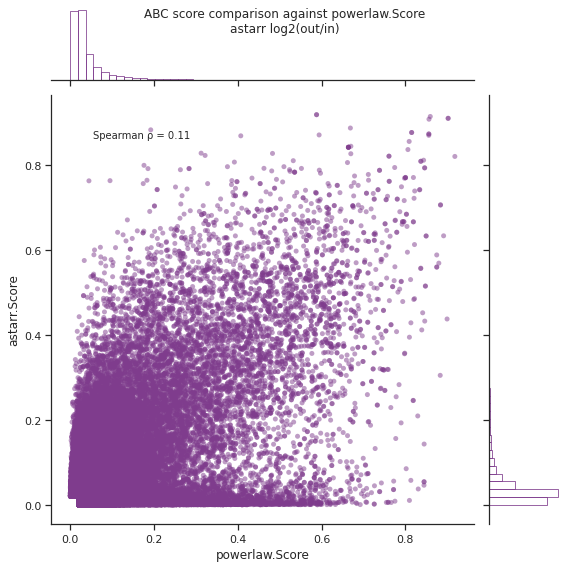

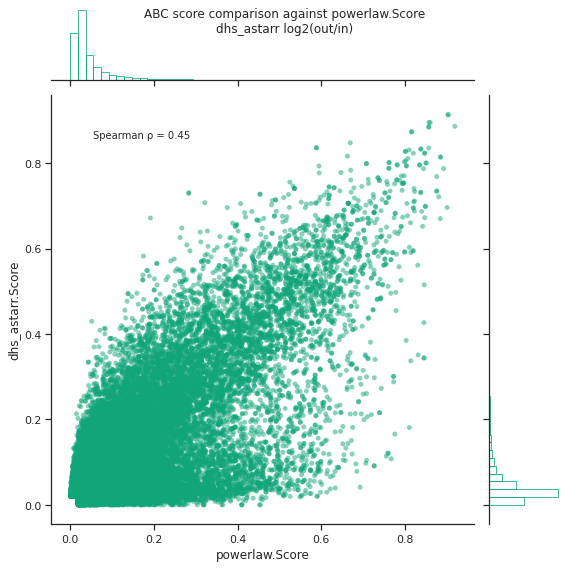

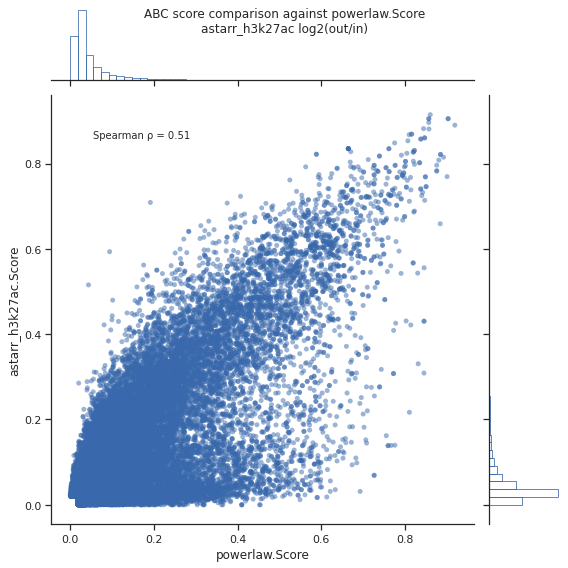

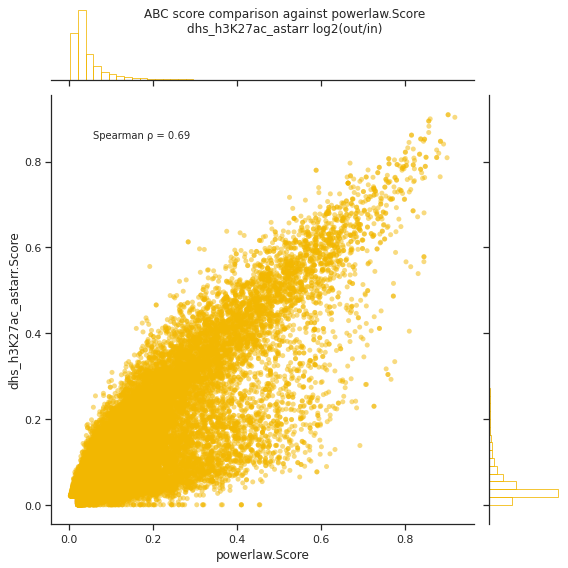

In [23]:
datadir='/data/reddylab/Alex/encode4_duke/ipynbs/jamborees/20220307_locusselect_nawg/results'
for s_ix, ss in enumerate(['astarr', 'dhs_astarr', 'astarr_h3k27ac', 'dhs_h3K27ac_astarr']):
    g= sns.jointplot(
        data=abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score', '%s.Score'%ss]], 
        x='powerlaw.Score', y='%s.Score'%ss, color=Bold_9.hex_colors[s_ix],
        marker="o", s=25, marginal_kws=dict(bins=50, fill=False), alpha=.5,height=8, 
        ec="none", joint_kws = dict(rasterized=False)
    )
    corrfunc(    
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['powerlaw.Score']].values.flatten(),
        abc_df.loc[np.any(abc_df.loc[:, ['powerlaw.Score','%s.Score'%ss]]>.02, axis=1),
                        ['%s.Score'%ss]].values.flatten(),
        ax=g.ax_joint, method='Spearman'
    )
    
    plt.suptitle("ABC score comparison against powerlaw.Score\n%s log2(out/in)" % ss)
    g.savefig('%s/abc_score_comparison.%s_log2fc_vs_powerlaw.pdf' % (datadir, ss))